In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import re
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
reviews = pd.read_csv('/content/drive/My Drive/LHL_Final_Project/Written_Reviews/reviews.csv')
breweries = pd.read_csv('/content/drive/My Drive/LHL_Final_Project/Written_Reviews/breweries.csv')
beer = pd.read_csv('/content/drive/My Drive/LHL_Final_Project/Written_Reviews/beers.csv')

In [4]:
df_reviews = reviews.copy()
df_breweries = breweries.copy()
df_beer = beer.copy()

In [5]:
print(df_reviews.shape)
print(df_breweries.shape)
print(df_beer.shape)

(9073128, 10)
(50347, 7)
(358873, 10)


In [6]:
print(df_reviews.isna().sum())
print("\n")
print(df_breweries.isna().sum())
print("\n")
print(df_beer.isna().sum())

beer_id           0
username       3815
date              0
text              0
look        3790018
smell       3790018
taste       3790018
feel        3790018
overall     3790018
score             0
dtype: int64


id             0
name           0
city          58
state      11271
country        6
notes         85
types          0
dtype: int64


id                  0
name                0
brewery_id          0
state           60726
country           154
style               1
availability        0
abv             38797
notes              46
retired             0
dtype: int64


In [7]:
# rename 'id' to 'beer_id' to avoid any confusion later
df_beer = df_beer.rename(columns={'id':'beer_id'})

# rename the id column as brewery_id so we can merge dataframes appropriately
df_breweries = df_breweries.rename(columns={'id':'brewery_id'})

In [8]:
print(df_reviews['beer_id'].nunique())
print(df_beer['beer_id'].nunique())
print(df_breweries['brewery_id'].nunique())

309542
358873
50347


In [9]:
df_reviews.dtypes

beer_id       int64
username     object
date         object
text         object
look        float64
smell       float64
taste       float64
feel        float64
overall     float64
score       float64
dtype: object

In [10]:
# df_reviews['date']=pd.to_datetime(df_reviews['date'],unit='s')
print(df_reviews['date'].min())
print(df_reviews['date'].max())

1996-08-22
2018-09-30


# Data Cleaning

* df_reviews: There are a lot of beer with no ratings and a few with no username. I will drop these.
* df_breweries: I'm not concerned about the state or the city, I don't plan on using those columns
* df_beer: I don't plan on using the state column, and will fill in the missing abv with the mean

In [11]:
df_reviews['text'] = df_reviews['text'].str.strip().replace('',np.nan)
df_reviews = df_reviews.dropna()
df_beer['abv'] = df_beer['abv'].fillna(df_beer['abv'].mean())

In [12]:
df_reviews = df_reviews.rename(columns={'score':'avg_score', 'overall':'user_overall_score'})

In [13]:
df_breweries = df_breweries.rename(columns={'name':'brewery_name'})
df_breweries = df_breweries[~df_breweries['brewery_name'].str.contains('DUPLICATE')]
df_breweries.head()

,brewery_id,brewery_name,city,state,country,notes,types
0,19730,Brouwerij Danny,Erpe-Mere,NaN,BE,No notes at this time.,Brewery
1,32541,Coachella Valley Brewing Co,Thousand Palms,CA,US,No notes at this time.,"Brewery, Bar, Beer-to-go"
2,44736,Beef 'O' Brady's,Plant City,FL,US,No notes at this time.,"Bar, Eatery"
3,23372,Broadway Wine Merchant,Oklahoma City,OK,US,No notes at this time.,Store
5,31561,Teddy's Tavern,Seattle,WA,US,No notes at this time.,"Bar, Beer-to-go"


In [14]:
df_beer = df_beer.rename(columns={'name':'beer_name'})
df_beer.head()

,beer_id,beer_name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [15]:
# I am only concerned about currently produced beer, so I will remove all the "t" rows from ['retired']
df_beer = df_beer.loc[df_beer['retired'] == 'f']

# Merging datasets

In [16]:
df = pd.merge(df_beer, df_breweries, on='brewery_id')
print(df.shape)
df.isna().sum()

(240480, 16)


beer_id             0
beer_name           0
brewery_id          0
state_x         45602
country_x         106
style               0
availability        0
abv                 0
notes_x            28
retired             0
brewery_name        0
city             1473
state_y         45513
country_y          17
notes_y           404
types               0
dtype: int64

In [17]:
# rename columns
df_brew_beer = df.rename(columns={'notes_x':'beer_notes', 
                             'notes_y':'brewery_notes', 
                             'state_x':'state',
                             'country_y':'country'})
# drop unneeded columns
df_brew_beer = df_brew_beer.drop(['state_y', 'country_x'], axis=1)

df_brew_beer.head()

,beer_id,beer_name,brewery_id,state,style,availability,abv,beer_notes,retired,brewery_name,city,country,brewery_notes,types
0,202522,Olde Cogitator,2199,CA,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f,Main Street Brewery,Pleasanton,US,No notes at this time.,"Brewery, Bar, Eatery"
1,8677,Red Leaf Strong Ale,2199,CA,American Strong Ale,Year-round,8.6,No notes at this time.,f,Main Street Brewery,Pleasanton,US,No notes at this time.,"Brewery, Bar, Eatery"
2,202536,Bikini Bottom,2199,CA,American Lager,Rotating,4.9,No notes at this time.,f,Main Street Brewery,Pleasanton,US,No notes at this time.,"Brewery, Bar, Eatery"
3,202523,Ded Hed Red,2199,CA,American Amber / Red Ale,Rotating,5.6,No notes at this time.,f,Main Street Brewery,Pleasanton,US,No notes at this time.,"Brewery, Bar, Eatery"
4,8749,Pleasanton Pale Ale,2199,CA,American Pale Ale (APA),Year-round,5.3,No notes at this time.,f,Main Street Brewery,Pleasanton,US,No notes at this time.,"Brewery, Bar, Eatery"


In [18]:
df_breweryBeer = df_brew_beer[['beer_id','beer_name','style','abv','brewery_id','brewery_name','country']]
print(df_breweryBeer.shape)
df_breweryBeer = df_breweryBeer.dropna()
print(df_breweryBeer.shape)

(240480, 7)
(240463, 7)


In [19]:
df = pd.merge(df_reviews, df_breweryBeer, on='beer_id')

In [20]:
df_beerReviews = df.copy()

In [21]:
print(df_beerReviews.shape)
df_beerReviews.head()

(2264673, 16)


,beer_id,username,date,text,look,smell,taste,feel,user_overall_score,avg_score,beer_name,style,abv,brewery_id,brewery_name,country
0,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally walked...,4.75,4.75,4.50,4.50,4.50,4.58,Haze,New England IPA,8.2,28743,Tree House Brewing Company,US
1,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouquet...,4.25,4.50,4.25,4.25,4.25,4.31,Haze,New England IPA,8.2,28743,Tree House Brewing Company,US
2,125646,MFMB,2017-12-16,Pours a creamy opaque light straw yellow with ...,4.75,4.50,4.50,4.50,4.50,4.52,Haze,New England IPA,8.2,28743,Tree House Brewing Company,US
3,125646,jngrizzaffi,2017-12-10,Pours a cloudy yellow color with a thin foamy ...,4.50,4.50,4.50,4.75,4.50,4.53,Haze,New England IPA,8.2,28743,Tree House Brewing Company,US
4,125646,PDOR1960,2017-12-08,Another great brew from Treehouse!!,4.50,4.50,4.50,4.50,4.50,4.50,Haze,New England IPA,8.2,28743,Tree House Brewing Company,US


In [22]:
# Remove Punctuation
import string
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
df_beerReviews['brewery_name'] = df_beerReviews['brewery_name'].apply(remove_punctuations)
df_beerReviews['beer_name'] = df_beerReviews['beer_name'].apply(remove_punctuations)
df_beerReviews['style'] = df_beerReviews['style'].apply(remove_punctuations)
df_beerReviews['country'] = df_beerReviews['country'].apply(remove_punctuations)


In [23]:
df_beerReviews.isna().sum()

beer_id               0
username              0
date                  0
text                  0
look                  0
smell                 0
taste                 0
feel                  0
user_overall_score    0
avg_score             0
beer_name             0
style                 0
abv                   0
brewery_id            0
brewery_name          0
country               0
dtype: int64

In [24]:
print('There are ', df_beerReviews['brewery_id'].nunique(), 'unique brewery IDs.')
print('There are ', df_beerReviews['brewery_name'].nunique(), 'unique brewery names.')
print("\n")
print('There are ', df_beerReviews['beer_id'].nunique(), 'unique beer IDs.')
print('There are ', df_beerReviews['beer_name'].nunique(), 'unique beer names.')
print("\n")
print('There are ', df_beerReviews['style'].nunique(), 'unique beer styles.')
print('The beers come from', df_beerReviews['country'].nunique(), 'countries')
print("\n")
print('There are ', df_beerReviews['username'].nunique(), 'unique reviewers.')


There are  8660 unique brewery IDs.
There are  8595 unique brewery names.


There are  90245 unique beer IDs.
There are  81067 unique beer names.


There are  111 unique beer styles.
The beers come from 155 countries


There are  77208 unique reviewers.


# Exploratory Data Analysis

In [25]:
df_beerReviews.head()

,beer_id,username,date,text,look,smell,taste,feel,user_overall_score,avg_score,beer_name,style,abv,brewery_id,brewery_name,country
0,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally walked...,4.75,4.75,4.50,4.50,4.50,4.58,Haze,New England IPA,8.2,28743,Tree House Brewing Company,US
1,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouquet...,4.25,4.50,4.25,4.25,4.25,4.31,Haze,New England IPA,8.2,28743,Tree House Brewing Company,US
2,125646,MFMB,2017-12-16,Pours a creamy opaque light straw yellow with ...,4.75,4.50,4.50,4.50,4.50,4.52,Haze,New England IPA,8.2,28743,Tree House Brewing Company,US
3,125646,jngrizzaffi,2017-12-10,Pours a cloudy yellow color with a thin foamy ...,4.50,4.50,4.50,4.75,4.50,4.53,Haze,New England IPA,8.2,28743,Tree House Brewing Company,US
4,125646,PDOR1960,2017-12-08,Another great brew from Treehouse!!,4.50,4.50,4.50,4.50,4.50,4.50,Haze,New England IPA,8.2,28743,Tree House Brewing Company,US


In [26]:
# To reduce my dataset size, I will only use users with over 100 reviews

no_ratings_by_user = df_beerReviews['username'].value_counts()
no_ratings_by_user = pd.DataFrame(no_ratings_by_user)
no_ratings_by_user = no_ratings_by_user.reset_index()
no_ratings_by_user = no_ratings_by_user[no_ratings_by_user.username > 99]
no_ratings_by_user = no_ratings_by_user.rename(columns={'index':'username', 'username':'number_of_reviews'})
no_ratings_by_user

,username,number_of_reviews
0,StonedTrippin,8167
1,metter98,6136
2,superspak,5855
3,UCLABrewN84,5769
4,biboergosum,5480
...,...,...
4080,ken3c,100
4081,Rockjocknroll,100
4082,leedorham,100
4083,Heavenisbeer,100


In [27]:
# Merge full dataset with reviewers, to get only reviewers with over 100 ratings
df_beerReviews = df_beerReviews[df_beerReviews['username'].isin(no_ratings_by_user['username'])]
df_beerReviews.shape

(1721644, 16)

In [28]:
df_beerReviews['username'].value_counts()

StonedTrippin    8167
metter98         6136
superspak        5855
UCLABrewN84      5769
biboergosum      5480
                 ... 
bourbonbock       100
Rockjocknroll     100
Schmidts          100
quirkzoo          100
flaminghomer      100
Name: username, Length: 4085, dtype: int64

In [29]:
# Check that I selected the correct rows
df_beerReviews['count'] = 1
df_beerReviews.groupby(['username']).sum().sort_values(by=['count'],ascending=False).reset_index()

,username,beer_id,look,smell,taste,feel,user_overall_score,avg_score,abv,brewery_id,count
0,StonedTrippin,1061678729,31530.75,31820.75,31875.25,31799.75,31913.00,31857.27,55388.456436,148949986,8167
1,metter98,575594107,23041.25,22559.50,23353.50,22629.00,23313.50,23073.31,41209.986622,78259543,6136
2,superspak,736492219,23850.50,22707.00,23571.50,23615.00,23457.50,23362.31,41761.222050,74935999,5855
3,UCLABrewN84,422234133,20540.25,21564.75,21307.25,21305.00,21229.25,21316.11,40770.450807,70080042,5769
4,biboergosum,568983261,21012.00,19902.00,20039.25,20196.75,20218.00,20124.73,34602.965597,67179390,5480
...,...,...,...,...,...,...,...,...,...,...,...
4080,bourbonbock,2147493,361.25,333.00,346.25,343.25,357.75,345.97,551.330000,177478,100
4081,Matty1918,887710,361.00,359.00,393.50,366.50,393.00,380.47,675.130000,203241,100
4082,MMOSNN,10473722,417.25,418.75,424.75,416.25,420.25,421.33,830.190000,1209710,100
4083,BltByKrmn,16986795,424.75,408.50,413.50,414.00,415.00,413.50,776.928504,2535022,100


In [30]:
# To reduce my dataset size, I will only use beer with over 200 reviews

number_of_reviews = df_beerReviews['beer_id'].value_counts()
number_of_reviews = pd.DataFrame(number_of_reviews)
number_of_reviews = number_of_reviews.reset_index()
number_of_reviews = number_of_reviews[number_of_reviews.beer_id > 199]
number_of_reviews = number_of_reviews.rename(columns={'index':'beer_id', 'beer_id':'number_of_ratings'})
number_of_reviews

,beer_id,number_of_ratings
0,412,2248
1,2093,2225
2,11757,2196
3,1904,2193
4,1093,2184
...,...,...
1704,33624,200
1705,259,200
1706,3279,200
1707,135684,200


In [31]:
# Merge full dataset with reviewers, to get only reviewers with over 100 ratings
df_beerReviews = df_beerReviews[df_beerReviews['beer_id'].isin(number_of_reviews['beer_id'])]
df_beerReviews.shape

(853486, 17)

In [32]:
df_beerReviews['beer_id'].value_counts()

412      2248
2093     2225
11757    2196
1904     2193
1093     2184
         ... 
3279      200
259       200
42349     200
9962      200
33624     200
Name: beer_id, Length: 1709, dtype: int64

In [33]:
# # Adding a total average review for each beer column
# review_df['global_avg_rating'] = (review_df['user_overall_score']/review_df['count']).round(2)
# avg = review_df[['beer_id','global_avg_rating']]
# avg.sort_values('global_avg_rating',ascending=False)

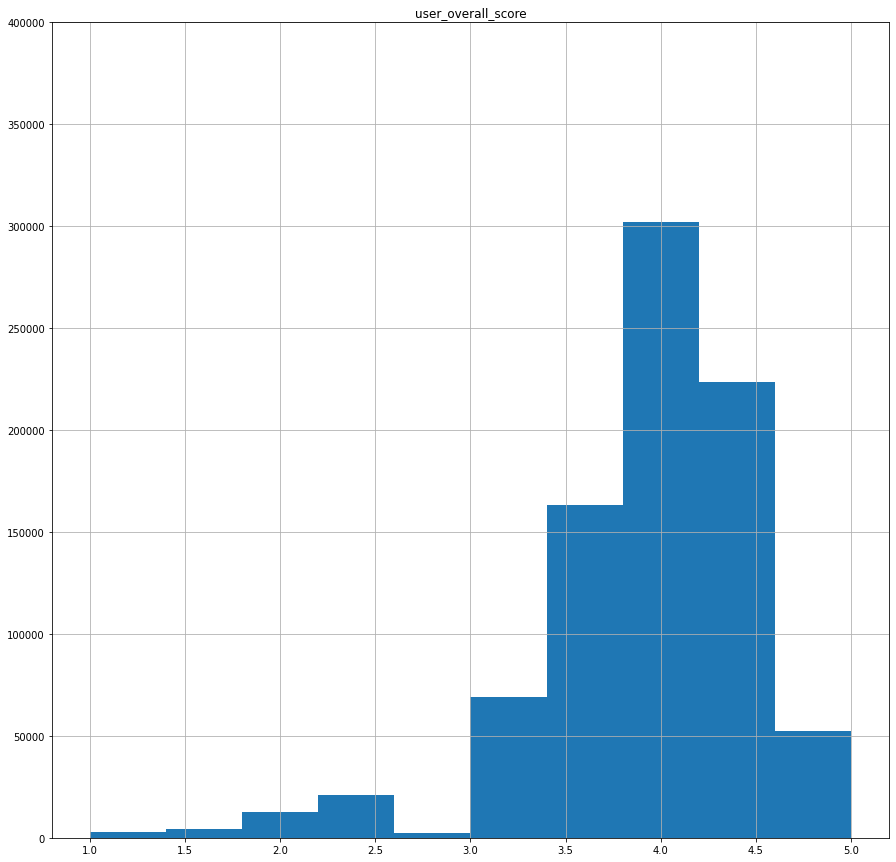

In [34]:
#score distributions
df_beerReviews[['user_overall_score']].hist(figsize=(15,15))
plt.ylim(0,400000)
plt.show()

It looks like users are more likely to leave positive reviews instead of negative reviews

## Reviewers

In [35]:
#group the reviews by username in a new column called "user_count"
reviewers = df_beerReviews.copy()
reviewers['review_count'] = reviewers['username'].groupby(reviewers['username']).transform('count')
#create column containing average review score left by each user
reviewers['user_avg_score'] = reviewers['avg_score'].groupby(reviewers['username']).transform('mean').round(2)

Text(0.5, 1.0, 'User Review Plot')

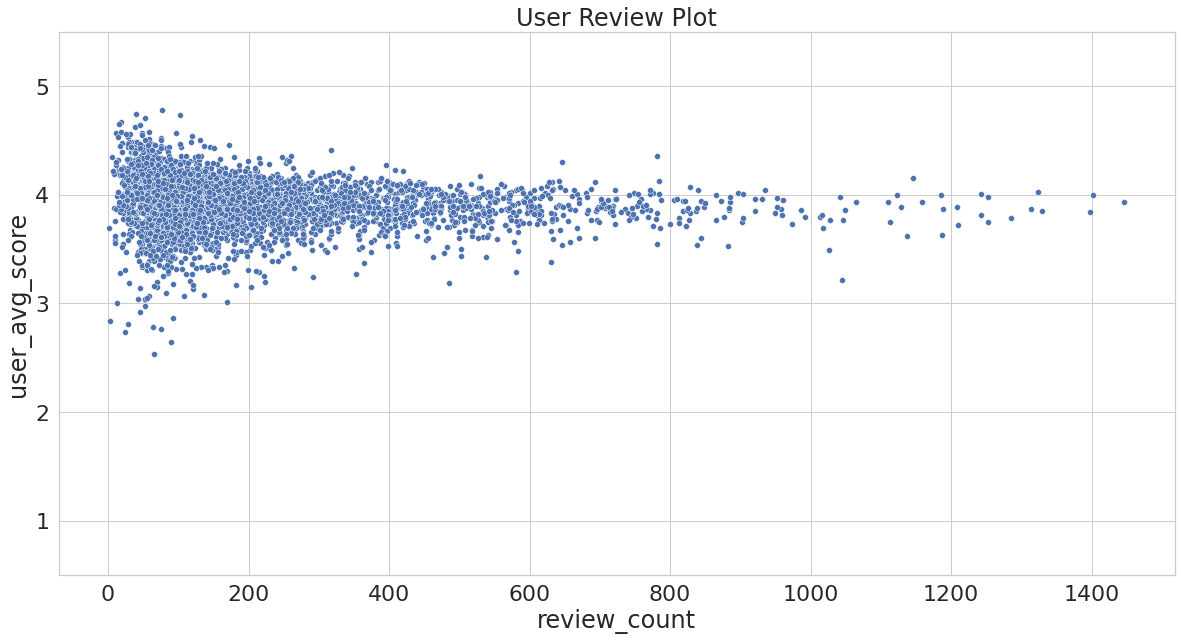

In [36]:
# Dataset with unique useranmes
reviews_v2 = reviewers.drop_duplicates('username')

#build a scatterplot representing each user's average score vs review count
plt.figure(figsize=(20,10))
sns.set(font_scale=2)
sns.set_style("whitegrid")
ax = sns.scatterplot(x='review_count', y='user_avg_score', data=reviews_v2)
ax.set(ylim=(0.5, 5.5))
plt.title('User Review Plot')

Most reviewers only leave positive reviews.

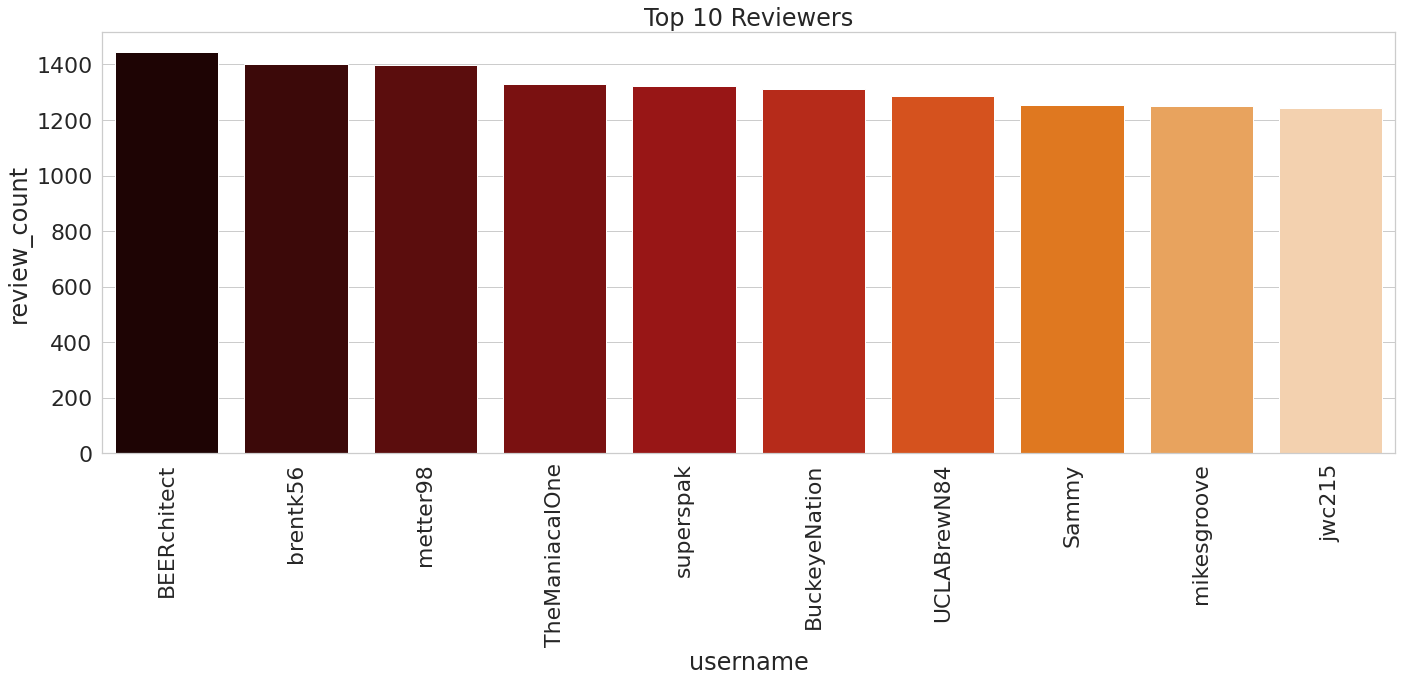

In [37]:
#build a df with the top 20 reviewers by review count
top_20 = reviewers.drop_duplicates('review_count').sort_values(by=['review_count'], ascending=False).head(10)

#plot the top 10 reviewers
plt.figure(figsize=(20,10))
ax = sns.barplot(x='username', y="review_count", data=top_20, palette='gist_heat')
plt.title('Top 10 Reviewers')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

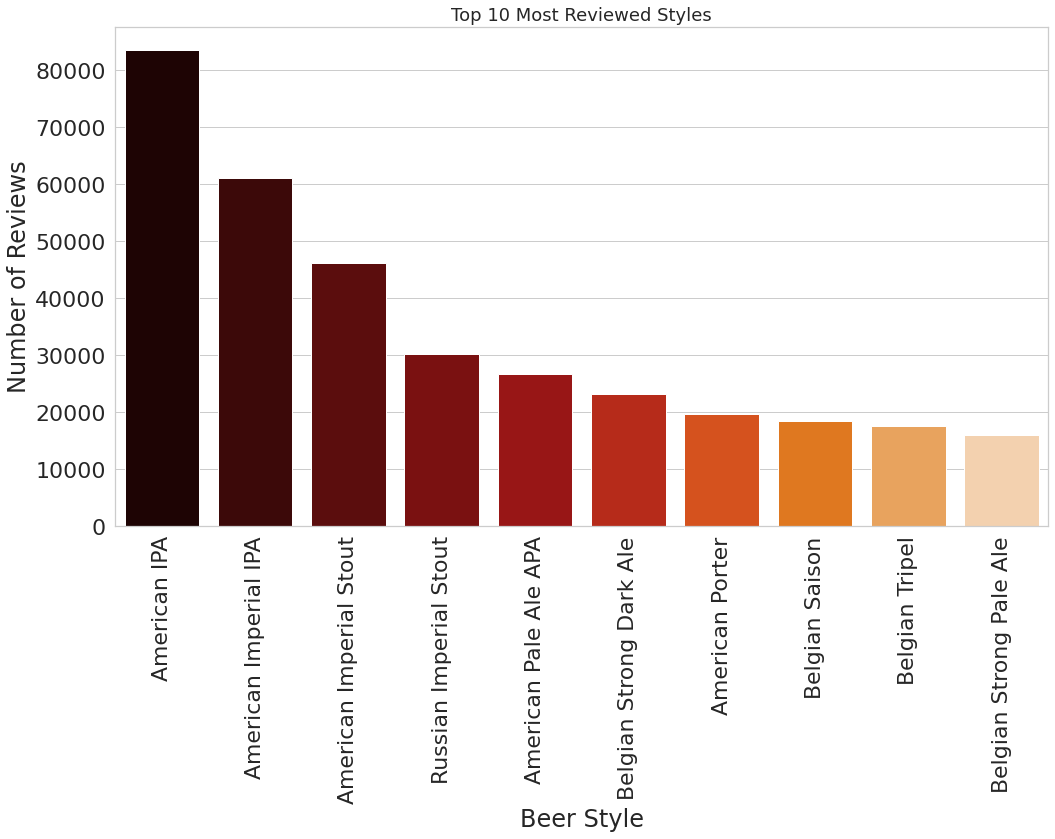

In [38]:
#group the styles by review count to reveal the most popular styles
df_beerReviews['style_count'] = df_beerReviews['style'].groupby(df_beerReviews['style']).transform('count')

#create a df with the top 10 most reviewed styles
top_10 = df_beerReviews.drop_duplicates('style_count').sort_values(by=['style_count'], ascending=False).head(10)

#plot the top 10 most reviewed styles
plt.figure(figsize=(15,12))
ax = sns.barplot(x='style', y='style_count', data=top_10, palette='gist_heat')
sns.set(font_scale=1.5)
plt.title('Top 10 Most Reviewed Styles')
plt.ylabel('Number of Reviews')
plt.xlabel('Beer Style')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

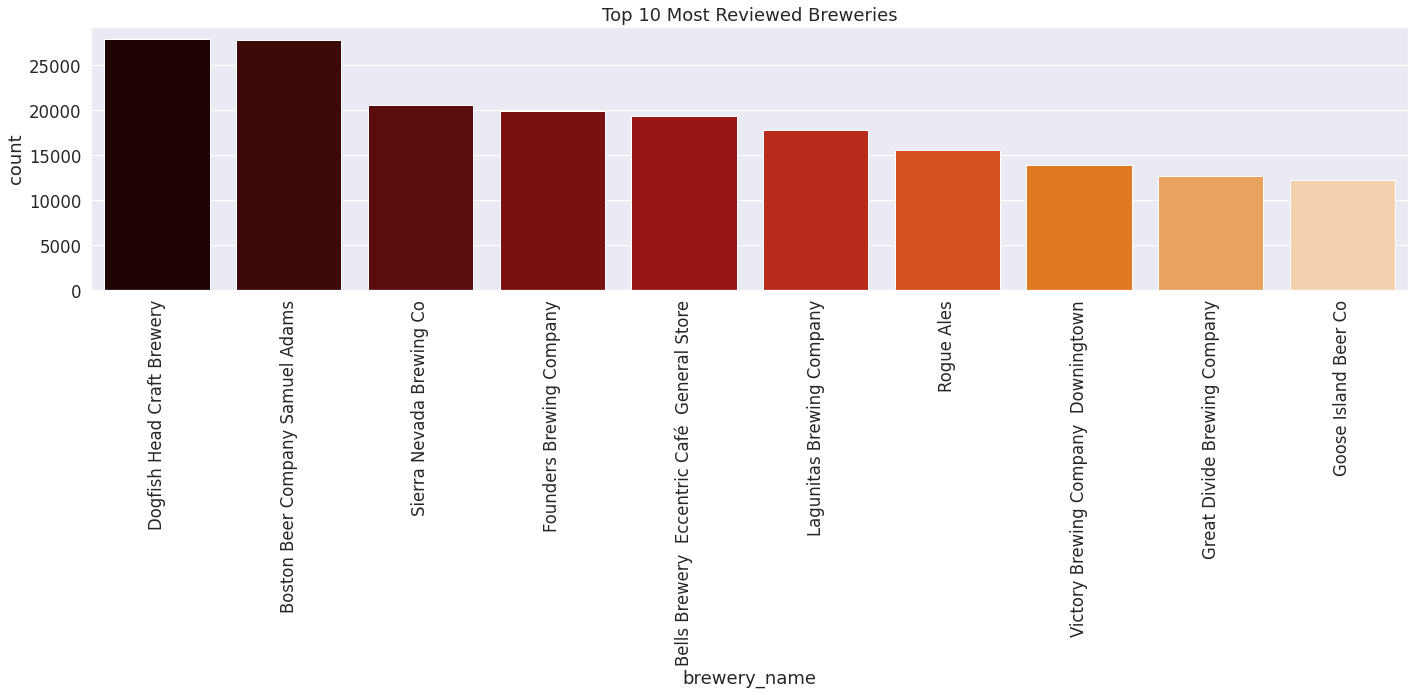

In [39]:
highest2 = df_beerReviews.groupby(['brewery_name']).sum().sort_values(by=['count'],ascending=False).reset_index().head(10)

#plot the top 10 most reviewed breweries
plt.figure(figsize=(20,10))
ax = sns.barplot(x='brewery_name', y="count", data=highest2, palette='gist_heat')
plt.title('Top 10 Most Reviewed Breweries')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

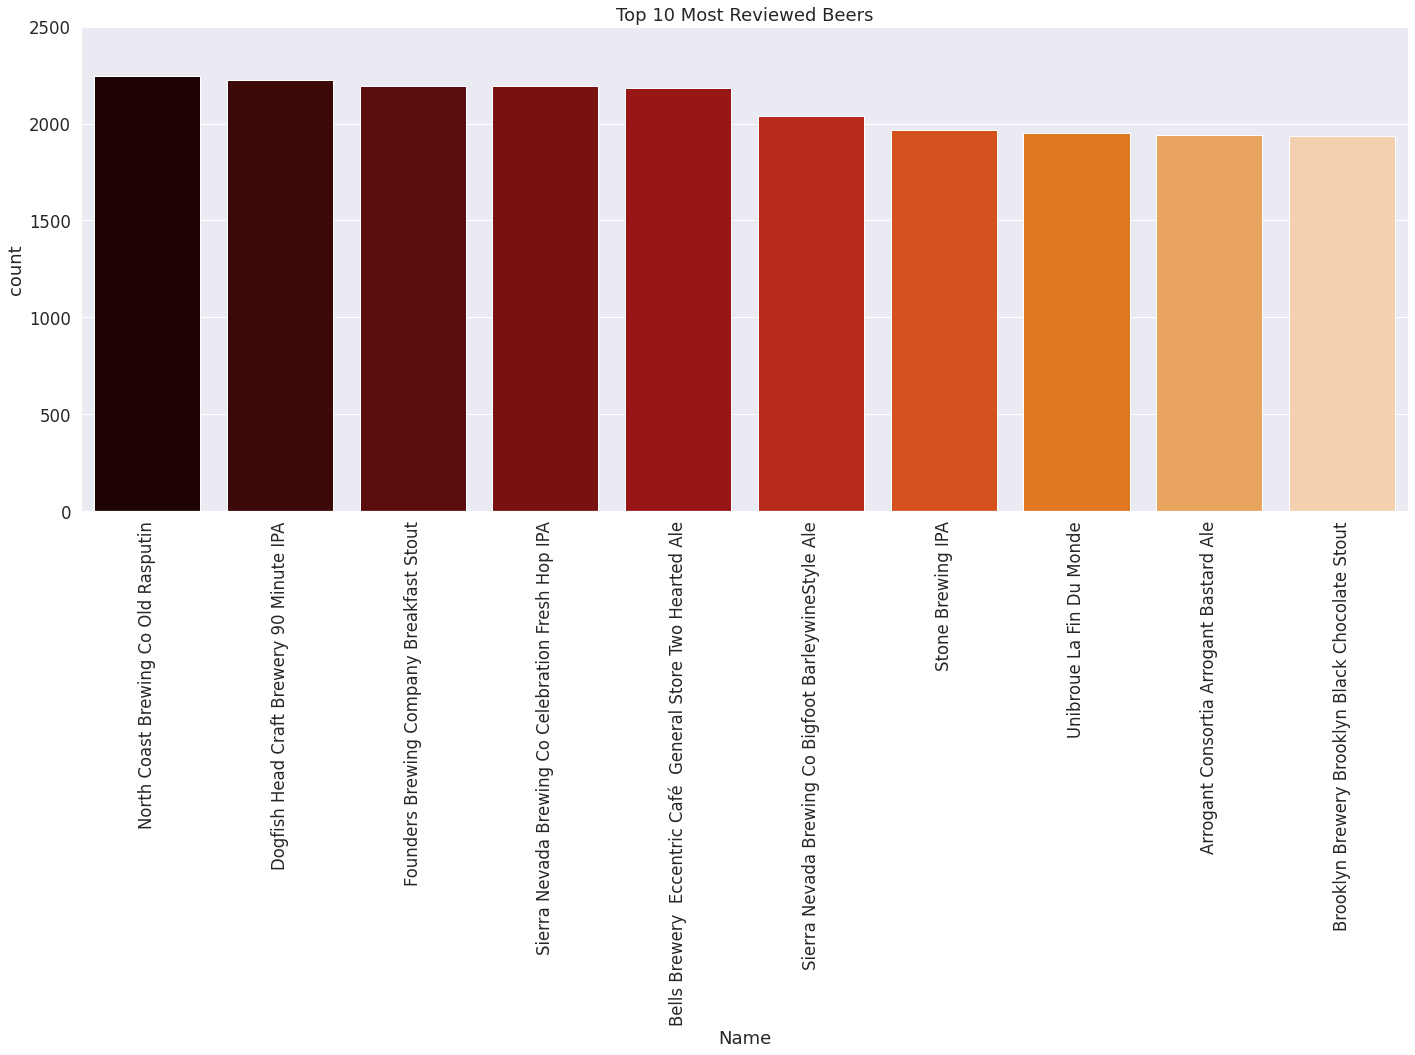

In [54]:
df_beerReviews['Name'] = df_beerReviews['brewery_name'] +' '+ df_beerReviews['beer_name']
highest2 = df_beerReviews.groupby(['Name']).sum().sort_values(by=['count'],ascending=False).reset_index().head(10)

#plot the top 10 most reviewed breweries
plt.figure(figsize=(20,15))
ax = sns.barplot(x='Name', y="count", data=highest2, palette='gist_heat')
plt.title('Top 10 Most Reviewed Beers')
plt.xticks(rotation=90)
plt.ylim(0,2500)
plt.tight_layout()
plt.show()

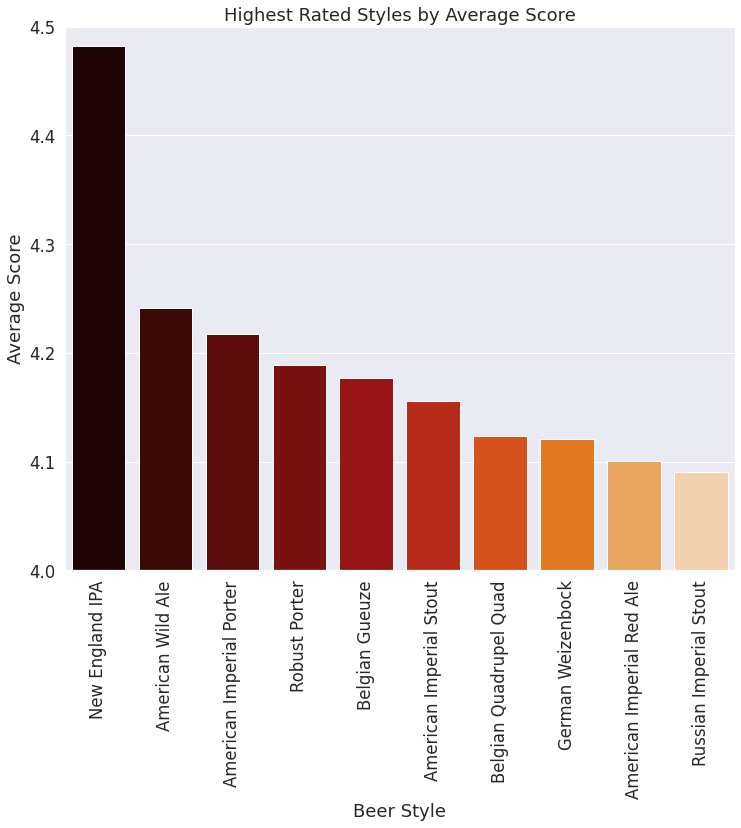

In [41]:
#plot the highest rated styles (by average score)
highest = df_beerReviews.groupby('style')['user_overall_score'].mean().nlargest(10).reset_index()
highest = pd.DataFrame(highest)

plt.figure(figsize=(12, 10))
ax = sns.barplot(x='style', y='user_overall_score', data=highest, palette='gist_heat')
plt.title('Highest Rated Styles by Average Score')
plt.ylabel('Average Score')
plt.xlabel('Beer Style')
plt.xticks(rotation=90)
plt.ylim(4,4.5)
plt.show()

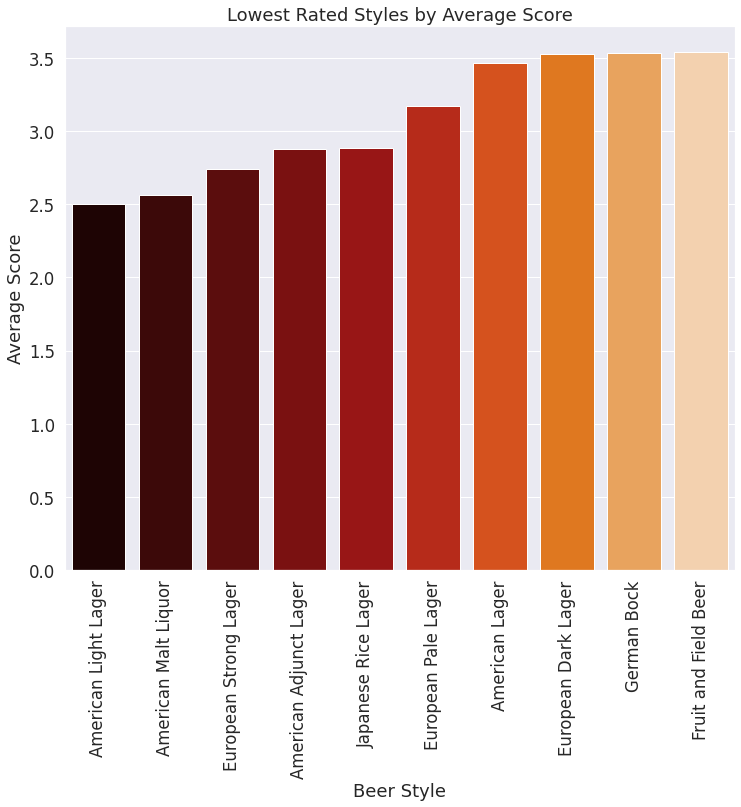

In [42]:
#plot the lowest rated styles (by average score)
lowest = df_beerReviews.groupby('style')['user_overall_score'].mean().nsmallest(10).reset_index()
lowest = pd.DataFrame(lowest)

plt.figure(figsize=(12, 10))
ax = sns.barplot(x='style', y='user_overall_score', data=lowest, palette='gist_heat')
plt.title('Lowest Rated Styles by Average Score')
plt.ylabel('Average Score')
plt.xlabel('Beer Style')
plt.xticks(rotation=90)
plt.show()

In [57]:
asc_pie_data

,country,brewery_name
35,US,634581
3,BE,79789
9,DE,44490
15,GB,36936
5,CA,16051
17,IE,6851
25,NL,5328
24,MX,5069
10,DK,3648
21,JP,3025


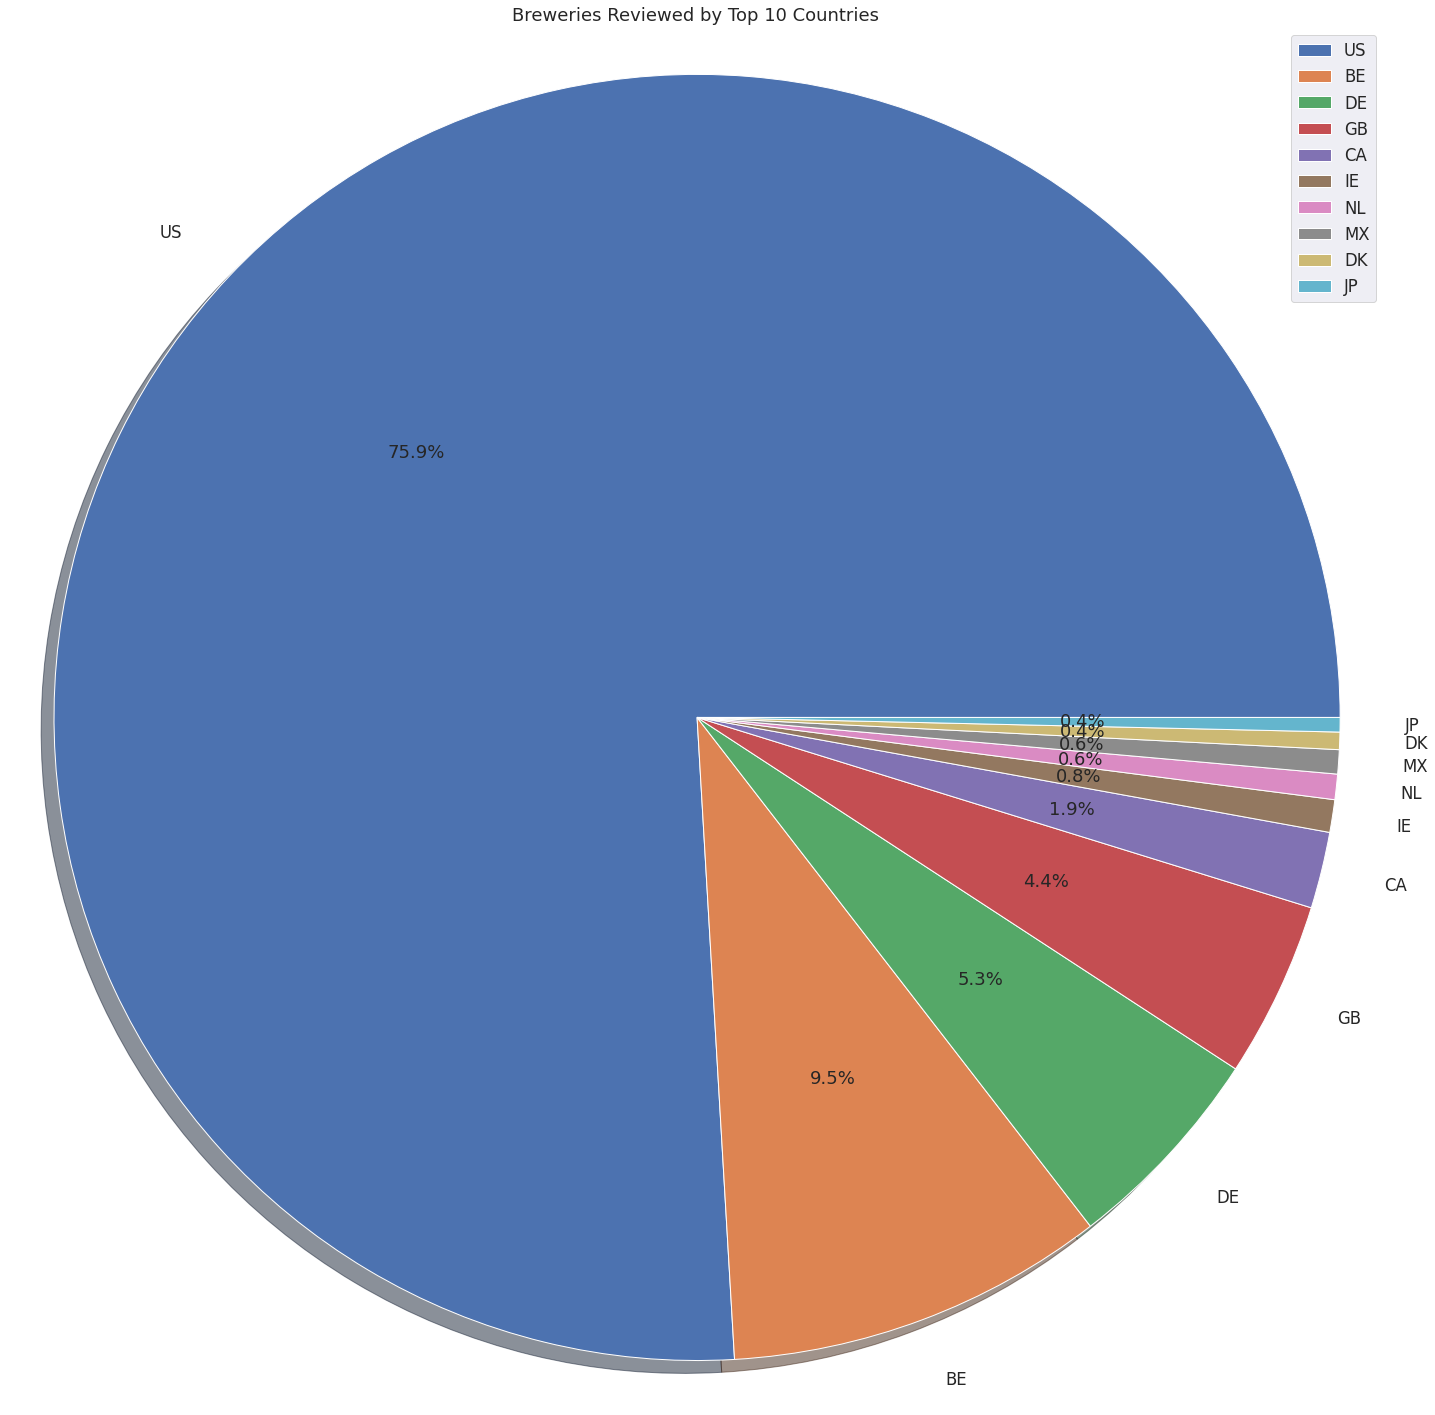

In [56]:
#let's make a visualization showing the distribution of countries in the dataset
df_breweries = df_beerReviews[['country', 'brewery_name']]
pie_data = df_breweries.groupby('country').count().reset_index()
asc_pie_data = pie_data.sort_values(by='brewery_name', ascending=False).head(10)

#plot the number of breweries reviewed by country
countries = asc_pie_data['country']
locations = asc_pie_data['brewery_name']

plt.figure(figsize=(20,20))
plt.pie(locations, shadow=True, labels=countries, autopct='%.1f%%')
plt.legend(countries, loc='best')
plt.axis('equal')
plt.title('Breweries Reviewed by Top 10 Countries')

plt.tight_layout()
plt.show()

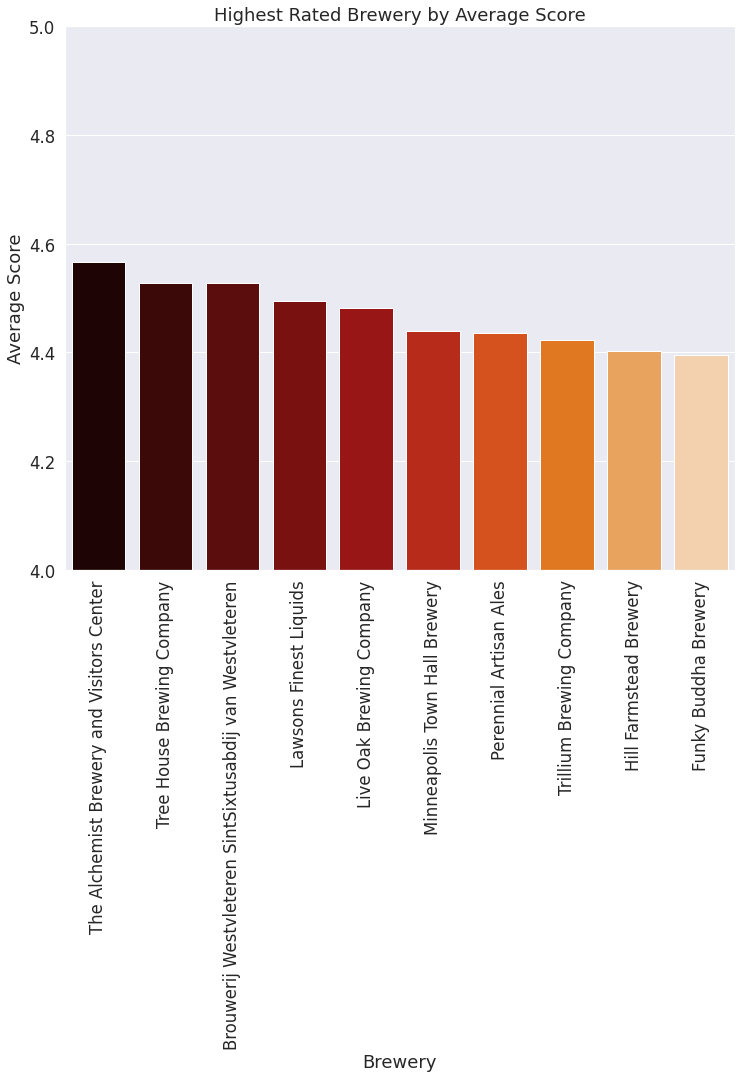

In [44]:
#plot the highest rated brewery (by average score)
highest = df_beerReviews.groupby('brewery_name')['user_overall_score'].mean().nlargest(10).reset_index()
highest = pd.DataFrame(highest)

plt.figure(figsize=(12, 10))
ax = sns.barplot(x='brewery_name', y='user_overall_score', data=highest, palette='gist_heat')
plt.title('Highest Rated Brewery by Average Score')
plt.ylabel('Average Score')
plt.xlabel('Brewery')
plt.xticks(rotation=90)
plt.ylim(4,5)
plt.show()

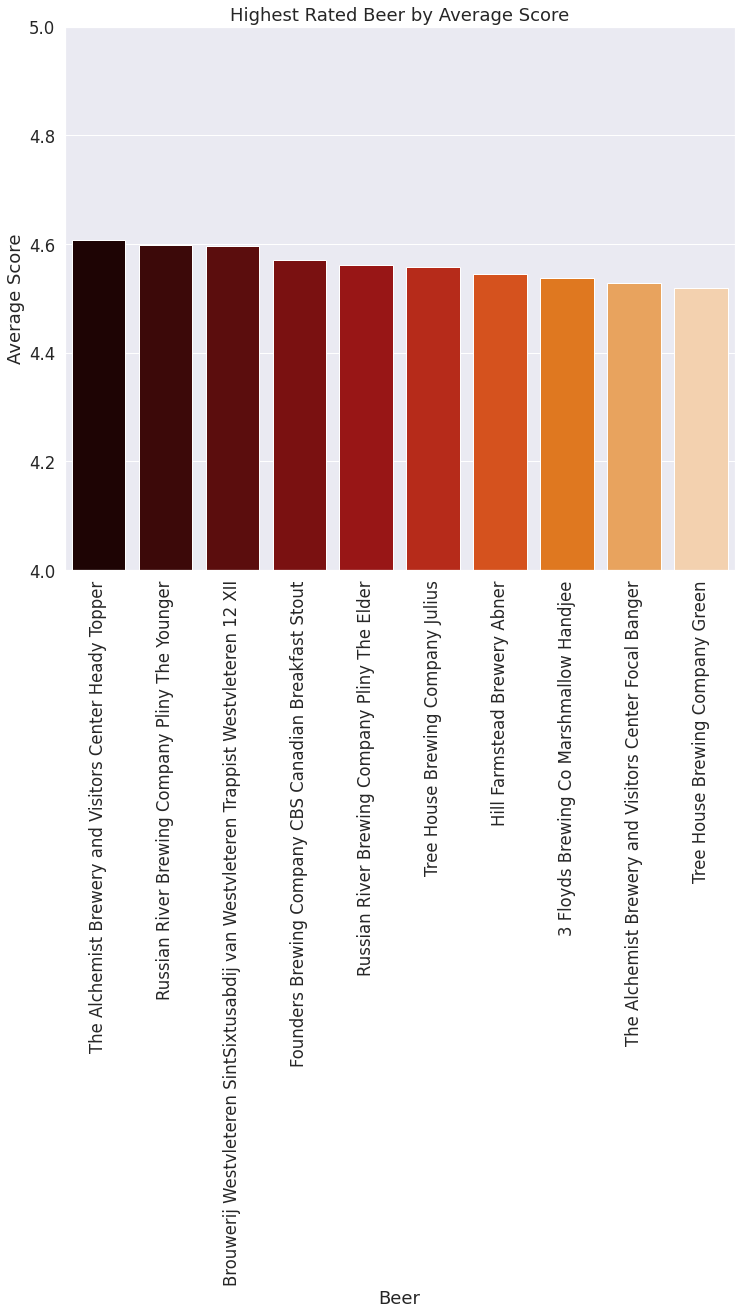

In [45]:
#plot the highest rated brewery (by average score)
highest = df_beerReviews.groupby(by = 'Name')['user_overall_score'].mean().nlargest(10).reset_index()
highest = pd.DataFrame(highest)

plt.figure(figsize=(12, 10))
ax = sns.barplot(x='Name', y='user_overall_score', data=highest, palette='gist_heat')
plt.title('Highest Rated Beer by Average Score')
plt.ylabel('Average Score')
plt.xlabel('Beer')
plt.xticks(rotation=90)
plt.ylim(4,5)
plt.show()

In [46]:
# #plot the highest rated beer (by average score)
# highest = df_beerReviews.groupby('beer_name')['user_overall_score'].mean().reset_index()
# highest = pd.DataFrame(highest)

# plt.figure(figsize=(12, 10))
# ax = sns.lineplot(x='beer_name', y='user_overall_score', data=highest, palette='gist_heat')
# plt.title('Highest Rated Brewery by Average Score')
# plt.ylabel('Average Score')
# plt.xlabel('Brewery')
# plt.xticks(rotation=90)
# plt.ylim(4,5.5)
# plt.show()

In [47]:
df_beerReviews.isna().sum()

beer_id               0
username              0
date                  0
text                  0
look                  0
smell                 0
taste                 0
feel                  0
user_overall_score    0
avg_score             0
beer_name             0
style                 0
abv                   0
brewery_id            0
brewery_name          0
country               0
count                 0
style_count           0
Name                  0
dtype: int64

In [48]:
df_beerReviews.shape

(853486, 19)

In [49]:
from google.colab import files
df_beerReviews.to_csv('Beer_Recommendations_EDA_V01.csv') 
files.download('Beer_Recommendations_EDA_V01.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
# Write the DataFrame to CSV file.
with open('/content/drive/My Drive/LHL_Final_Project/Written_Reviews/Beer_Recommendations_EDA_V01.csv', 'w') as f:
  df.to_csv(f)

In [51]:
from google.colab import drive
drive.mount('drive')

df_beerReviews.to_csv('/content/drive/My Drive/LHL_Final_Project/Written_Reviews/Beer_Recommendations_EDA_V01.csv', encoding='utf-8', index=False)

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).
